## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [1]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

We will first split the data and then apply CounVectorizer, so we can prevent any data leakage.

We will do some data preprocessing, so the model yells the best results.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(reviews[0], Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [4]:
X_train

<16000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 2010883 stored elements in Compressed Sparse Row format>

We got a Sparse Matrix as a result in which each row is a review and each column is one of the 10 000 most frequent words we set in the CountVectorizer. Each value represents how many times a given word appear in a given review.

In [5]:
print(X_train[0])

feature_names = vectorizer.get_feature_names_out()


print("First word in the vocabulary:", feature_names[8954])

  (0, 8954)	5
  (0, 5652)	1
  (0, 4894)	1
  (0, 1731)	2
  (0, 6163)	4
  (0, 7662)	1
  (0, 9073)	1
  (0, 9680)	1
  (0, 1826)	1
  (0, 3518)	2
  (0, 4722)	2
  (0, 9312)	1
  (0, 8007)	1
  (0, 8334)	1
  (0, 2847)	1
  (0, 1206)	2
  (0, 1769)	1
  (0, 9079)	2
  (0, 9760)	1
  (0, 7764)	1
  (0, 5378)	1
  (0, 3748)	1
  (0, 9434)	1
  (0, 8995)	2
  (0, 4301)	1
  :	:
  (0, 9772)	1
  (0, 6861)	1
  (0, 9748)	1
  (0, 1353)	1
  (0, 5088)	1
  (0, 6203)	1
  (0, 8981)	1
  (0, 4473)	2
  (0, 6398)	1
  (0, 2667)	1
  (0, 6268)	1
  (0, 5859)	1
  (0, 9905)	1
  (0, 5851)	1
  (0, 6446)	1
  (0, 4903)	1
  (0, 505)	1
  (0, 9151)	1
  (0, 2606)	1
  (0, 4709)	1
  (0, 6408)	1
  (0, 5603)	1
  (0, 8203)	1
  (0, 4196)	1
  (0, 7537)	1
First word in the vocabulary: the


As we can see 'the' is the more common word in the 1st sentence. We checked and it it thesame case for the 2nd and pretty sure for many others. So each record in the Sparse Matrix represents how many times a given word is contained in a given sentence/review. We tried to format the text by removing commmon words as the, these, etc but there was no improvement in the model, so we decided that we will stick to the original data.

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU found. Using CPU instead.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
tf.random.set_seed(42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


adam = Adam(learning_rate=0.001)

model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train.toarray(),
    y_train.to_numpy(),
    epochs=50,
    batch_size=32,
    validation_data=(X_val.toarray(), y_val.to_numpy()),
    callbacks=[early_stopping]
)


Epoch 1/50
500/500 [==============================] - 5s 6ms/step - loss: 0.7102 - accuracy: 0.8033 - val_loss: 0.6388 - val_accuracy: 0.8533
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 0.6428 - accuracy: 0.8361 - val_loss: 0.6198 - val_accuracy: 0.8457
Epoch 3/50
500/500 [==============================] - 2s 5ms/step - loss: 0.6386 - accuracy: 0.8381 - val_loss: 0.6287 - val_accuracy: 0.8622
Epoch 4/50
500/500 [==============================] - 3s 6ms/step - loss: 0.6347 - accuracy: 0.8411 - val_loss: 0.6294 - val_accuracy: 0.8650
Epoch 5/50
500/500 [==============================] - 3s 6ms/step - loss: 0.6404 - accuracy: 0.8397 - val_loss: 0.6301 - val_accuracy: 0.8610
Epoch 6/50
500/500 [==============================] - 3s 6ms/step - loss: 0.6314 - accuracy: 0.8440 - val_loss: 0.6026 - val_accuracy: 0.8673
Epoch 7/50
500/500 [==============================] - 2s 4ms/step - loss: 0.6350 - accuracy: 0.8436 - val_loss: 0.6368 - val_accuracy: 0.8595
Epoch 

In [14]:
model.save('model.h5')

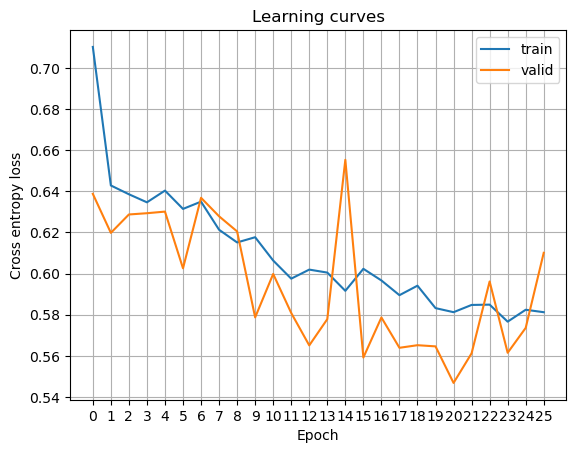

In [11]:
history_loss_values = history.history['loss']
history_val_loss_values = history.history['val_loss']

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history_loss_values, label='train')
plt.plot(history_val_loss_values, label='valid')
plt.xticks(range(0, len(history_loss_values), 1))
plt.grid()
plt.legend()
plt.show()

**(d)** Test your sentiment-classifier on the test set.

In [12]:
test_loss, test_accuracy = model.evaluate(X_test.toarray(), y_test.to_numpy(), verbose=0)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.875


**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [13]:
sample_sentences = [
    "This movie was fantastic! I really enjoyed it.",
    "The film was terrible and a waste of time.",
    "An average movie with some good and bad moments.",
    "Absolutely loved the storyline and the characters.",
    "I did not like the movie at all."
]

sample_sentences_transformed = vectorizer.transform(sample_sentences)

predictions = model.predict(sample_sentences_transformed)

for sentence, pred in zip(sample_sentences, predictions):
    positive_confidence = pred[0] * 100
    negative_confidence = (1 - pred[0]) * 100
    predicted_label = 'positive' if positive_confidence > 50 else 'negative'
    print(f"Sentence: {sentence}\nPredicted Sentiment: {predicted_label} ({positive_confidence:.2f}% positive, {negative_confidence:.2f}% negative)\n")

1/1 [==============================] - 0s 15ms/step
Sentence: This movie was fantastic! I really enjoyed it.
Predicted Sentiment: positive (82.16% positive, 17.84% negative)

Sentence: The film was terrible and a waste of time.
Predicted Sentiment: negative (14.35% positive, 85.65% negative)

Sentence: An average movie with some good and bad moments.
Predicted Sentiment: negative (39.85% positive, 60.15% negative)

Sentence: Absolutely loved the storyline and the characters.
Predicted Sentiment: positive (67.63% positive, 32.37% negative)

Sentence: I did not like the movie at all.
Predicted Sentiment: negative (41.45% positive, 58.55% negative)

